In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
dataset = pd.read_csv('energydata_complete.csv', header=0, index_col=0)
dataset.head()


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [ ]:
#cek data isnull apa tidak
dataset.isnull().sum()

Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

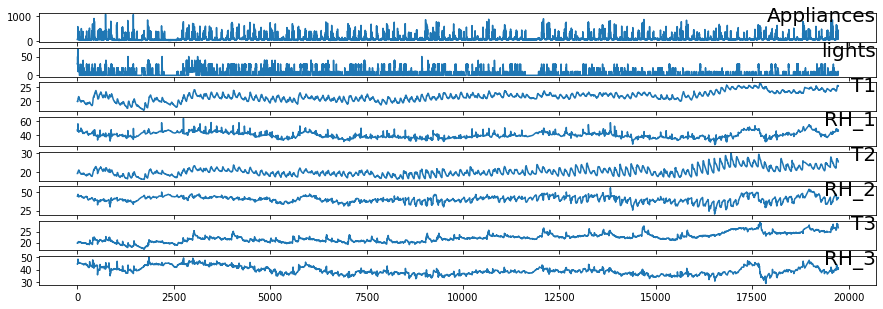

In [ ]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(15,5))
for group in groups:
  plt.subplot(len(groups), 1, i)
  plt.plot(values[:, group])
  plt.title(dataset.columns[group], y=0.5, loc='right', fontsize=20)
  i+=1;
plt.show()

In [ ]:
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# konversi series jadi data supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# gabung jadi satu
	agg = concat(cols, axis=1)
	agg.columns = names
	# hapus baris yang punya nilai NaN
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# memastikan data bertipe float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# hapus kolom yang tidak digunakan untuk prediksi
reframed.drop(reframed.columns[[8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var26(t)  var27(t)  var28(t)
1   0.046729   0.428571   0.327349  ...  0.533937  0.372083  0.372083
2   0.046729   0.428571   0.327349  ...  0.529412  0.572848  0.572848
3   0.037383   0.428571   0.327349  ...  0.524887  0.908261  0.908261
4   0.037383   0.571429   0.327349  ...  0.520362  0.201611  0.201611
5   0.046729   0.571429   0.327349  ...  0.515837  0.898441  0.898441

[5 rows x 36 columns]


In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 150 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3600, 1, 35) (3600,) (16134, 1, 35) (16134,)


In [ ]:
#konversi menjadi tipe numpy
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(train_X, window_size=64, batch_size=256, shuffle_buffer=1000)
valid_set = windowed_dataset(test_X, window_size=64, batch_size=256, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9) #lr=1.0000e-04 1e-5
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

In [ ]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=50, verbose=1,callbacks=[lr_schedule])

Epoch 1/50
113/113 [==============================] - 2s 13ms/step - loss: 0.1662 - mae: 0.4961 - val_loss: 0.1666 - val_mae: 0.4996
Epoch 2/50
113/113 [==============================] - 1s 8ms/step - loss: 0.1657 - mae: 0.4951 - val_loss: 0.1660 - val_mae: 0.4985
Epoch 3/50
113/113 [==============================] - 1s 8ms/step - loss: 0.1651 - mae: 0.4939 - val_loss: 0.1654 - val_mae: 0.4972
Epoch 4/50
113/113 [==============================] - 1s 8ms/step - loss: 0.1644 - mae: 0.4925 - val_loss: 0.1646 - val_mae: 0.4957
Epoch 5/50
113/113 [==============================] - 1s 8ms/step - loss: 0.1635 - mae: 0.4908 - val_loss: 0.1638 - val_mae: 0.4940
Epoch 6/50
113/113 [==============================] - 1s 8ms/step - loss: 0.1625 - mae: 0.4888 - val_loss: 0.1628 - val_mae: 0.4920
Epoch 7/50
113/113 [==============================] - 1s 8ms/step - loss: 0.1614 - mae: 0.4866 - val_loss: 0.1617 - val_mae: 0.4898
Epoch 8/50
113/113 [==============================] - 1s 8ms/step - loss: 0

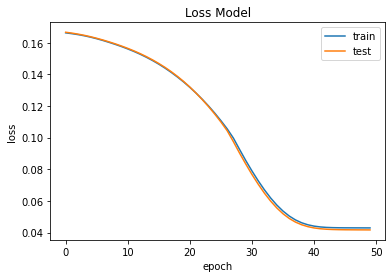

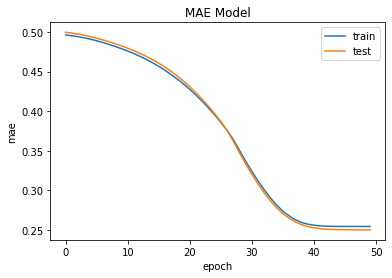

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()